In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

In [8]:
import os
data_dir= 'E:/Projects/Book_example/RNN_temp'
fname= os.path.join(data_dir,'jena_climate_2009_2016.csv')

with open(fname) as f:
    data=f.read()

lines=data.split('\n')
header=lines[0].split(',')
lines=lines[1:]

print(header)
print('Total have {} set of data'.format(len(lines)))


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Total have 420551 set of data


In [9]:
#parsing the data and convert to numpy
import numpy as np
float_data= np.zeros((len(lines), len(header) -1))


for i, line in enumerate(lines):
    values=[float(x) for x in line.split(',')[1:]]
 
   
    float_data[i,:] = values


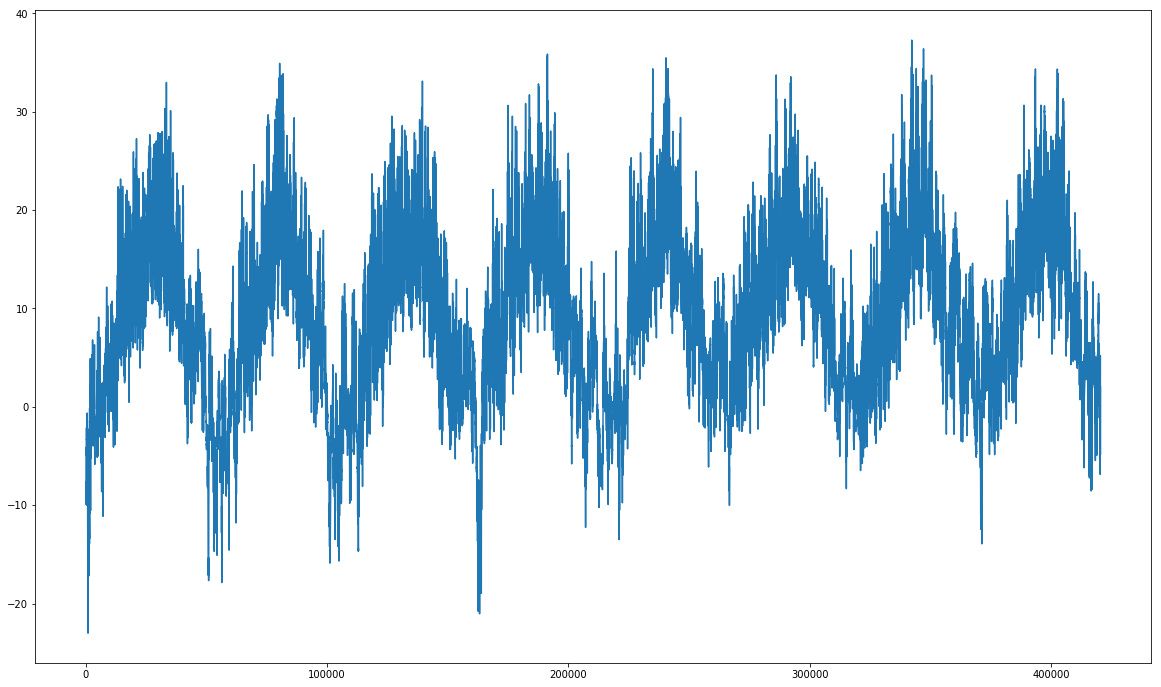

In [10]:
#plot temp timeseries
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 12))

temp=float_data[:,1] 
plt.plot(range(len(temp)), temp)


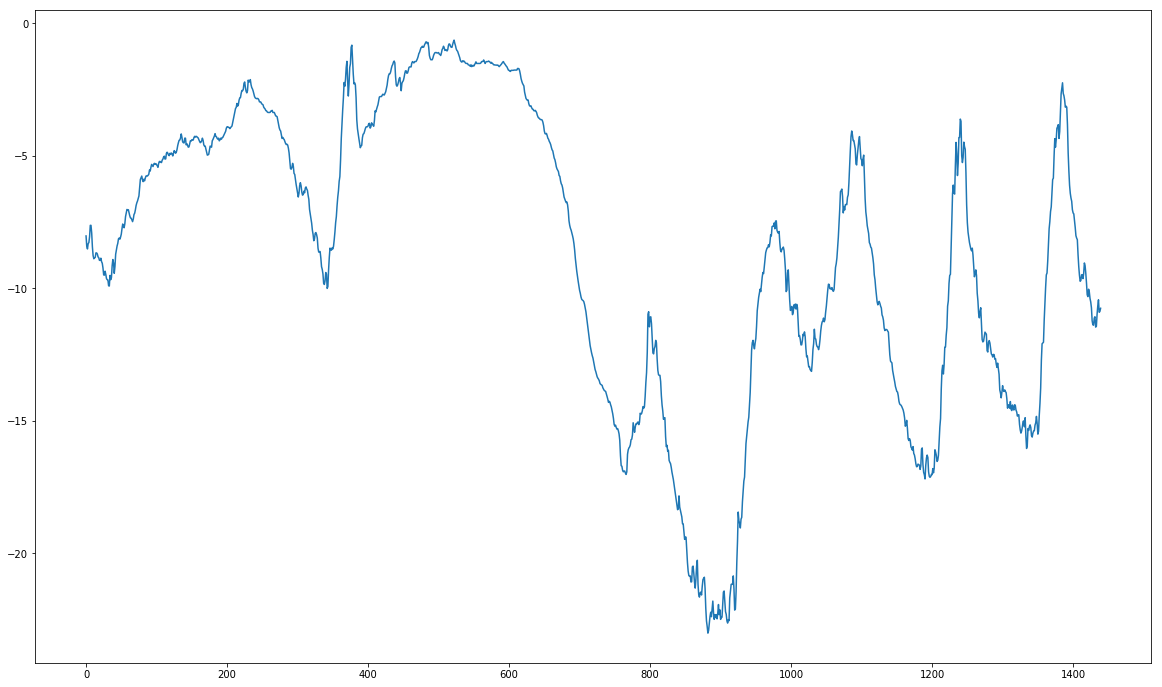

In [11]:
#plot the first 10 days of temp series
plt.figure(figsize=(20, 12))
plt.plot(range(1440), temp[:1440])

## Normalization of data
only use training sample size's mean and std to normalize the whole dataset

In [12]:
mean=float_data[:200000].mean(axis=0)


float_data-= mean

std=float_data[:200000].std(axis=0)
float_data/= std

In [13]:
float_data.shape

(420551, 14)

In [14]:
#Generator yielding timeseries samples and their target
def generator(data,lookback,delay,min_index,max_index,shuffle=False,batch_size=128,step=6):
    if max_index is None:
        max_index=len(data)-delay-1
    i=min_index+lookback
    while True:
        if shuffle:
            rows=np.random.randint(min_index+lookback, max_index, size=batch_size)

        else:
            if i+batch_size>=max_index:
                i=min_index+lookback
            rows=np.arange(i,min(i+batch_size,max_index))
            i+=len(rows)
        samples=np.zeros((len(rows),lookback//step, data.shape[-1]))
        targets=np.zeros((len(rows),))
        
        for j,row in enumerate(rows):
            indices=range(rows[j]-lookback, rows[j], step)
            samples[j]= data[indices]
            targets[j]=data[rows[j]+delay][1]
        yield samples, targets

In [15]:
lookback=1440
step=6
delay=144
batch_size=128

train_gen=generator(float_data,lookback=lookback,delay=delay,min_index=0, max_index=200000, shuffle=True, step=step,
                   batch_size= batch_size)

val_gen=generator(float_data,lookback=lookback,delay=delay,min_index=200001, max_index=300000, step=step,
                   batch_size= batch_size)

test_gen=generator(float_data,lookback=lookback,delay=delay,min_index=300001, max_index=None, step=step,
                   batch_size= batch_size)

train_steps=(200000-0-lookback)//batch_size

val_steps= (300000-200001-lookback)//batch_size #why have to - lookback?
print(val_steps,' steps to draw from val_gen to cover the entire validation set')

test_steps=(len(float_data)-300001-lookback)// batch_size
print(test_steps, 'steps to draw from test_gen to cover the entire test set')

769  steps to draw from val_gen to cover the entire validation set
930 steps to draw from test_gen to cover the entire test set


### with only Flatten Dense Layer withoutRNN

In [16]:
from keras.models import Sequential
from keras.layers import GRU, Dense, CuDNNGRU, Bidirectional, Flatten
from keras import optimizers

model4=Sequential()
model4.add(Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model4.add(Dense(32,activation='relu'))
model4.add(Dense(1))

model4.compile(optimizer=optimizers.RMSprop(), loss='mae') 
history4=model4.fit_generator(train_gen, steps_per_epoch=600,epochs=10, validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
600/600 [==============================] - 13s 21ms/step - loss: 1.0811 - val_loss: 0.4559
Epoch 2/10
600/600 [==============================] - 11s 18ms/step - loss: 0.3632 - val_loss: 0.2909
Epoch 3/10
600/600 [==============================] - 11s 18ms/step - loss: 0.2756 - val_loss: 0.2926
Epoch 4/10
600/600 [==============================] - 11s 18ms/step - loss: 0.2547 - val_loss: 0.3154
Epoch 5/10
600/600 [==============================] - 11s 18ms/step - loss: 0.2433 - val_loss: 0.3137
Epoch 6/10
600/600 [==============================] - 11s 18ms/step - loss: 0.2347 - val_loss: 0.3171
Epoch 7/10
600/600 [==============================] - 11s 18ms/step - loss: 0.2280 - val_loss: 0.3143
Epoch 8/10
600/600 [==============================] - 11s 18ms/step - loss: 0.2227 - val_loss: 0.3173
Epoch 9/10
600/600 [==============================] - 11s 18ms/s

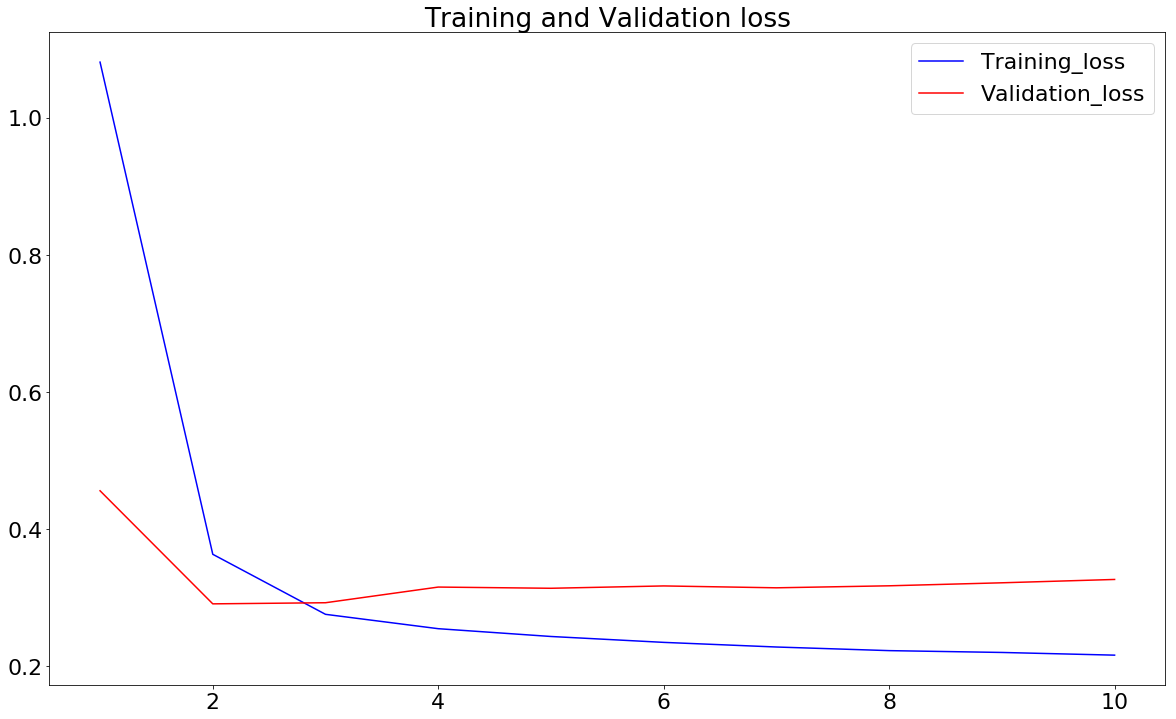

0.2161066039899985
error_in_temp is  1.913083513479819


In [17]:
#plot result
import matplotlib.pyplot as plt

loss= history4.history['loss']
val_loss=history4.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure(figsize=(20, 12))
plt.rcParams.update({'font.size': 22})

plt.plot(epochs,loss,'b',label='Training_loss')
plt.plot(epochs,val_loss,'r',label='Validation_loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

final_mae=history4.history['loss'][-1]
print(final_mae)

#reverse to get back the un standardized form

error_in_temp= final_mae*std[1]
print('error_in_temp is ',error_in_temp )

### One GRU with 1 Dense layer

In [18]:
#train and evalate a densely connected model
from keras.models import Sequential
from keras.layers import GRU, Dense, CuDNNGRU
from keras import optimizers

model=Sequential()
model.add(CuDNNGRU(32,input_shape=(None,float_data.shape[-1])))
model.add(Dense(1))
model.compile(optimizer=optimizers.RMSprop(), loss='mae') 


history=model.fit_generator(train_gen, steps_per_epoch=600,epochs=10, validation_data=val_gen,                        
                            validation_steps=val_steps)



Epoch 1/10
600/600 [==============================] - 14s 24ms/step - loss: 0.3025 - val_loss: 0.2763
Epoch 2/10
600/600 [==============================] - 13s 22ms/step - loss: 0.2824 - val_loss: 0.2651
Epoch 3/10
600/600 [==============================] - 13s 22ms/step - loss: 0.2753 - val_loss: 0.2623
Epoch 4/10
600/600 [==============================] - 13s 22ms/step - loss: 0.2710 - val_loss: 0.2656
Epoch 5/10
600/600 [==============================] - 13s 22ms/step - loss: 0.2659 - val_loss: 0.2629
Epoch 6/10
600/600 [==============================] - 13s 22ms/step - loss: 0.2591 - val_loss: 0.2677
Epoch 7/10
600/600 [==============================] - 13s 22ms/step - loss: 0.2535 - val_loss: 0.2674
Epoch 8/10
600/600 [==============================] - 13s 22ms/step - loss: 0.2490 - val_loss: 0.2694
Epoch 9/10
600/600 [==============================] - 13s 22ms/step - loss: 0.2446 - val_loss: 0.2695
Epoch 10/10
600/600 [==============================] - 13s 22ms/step - loss: 0.238

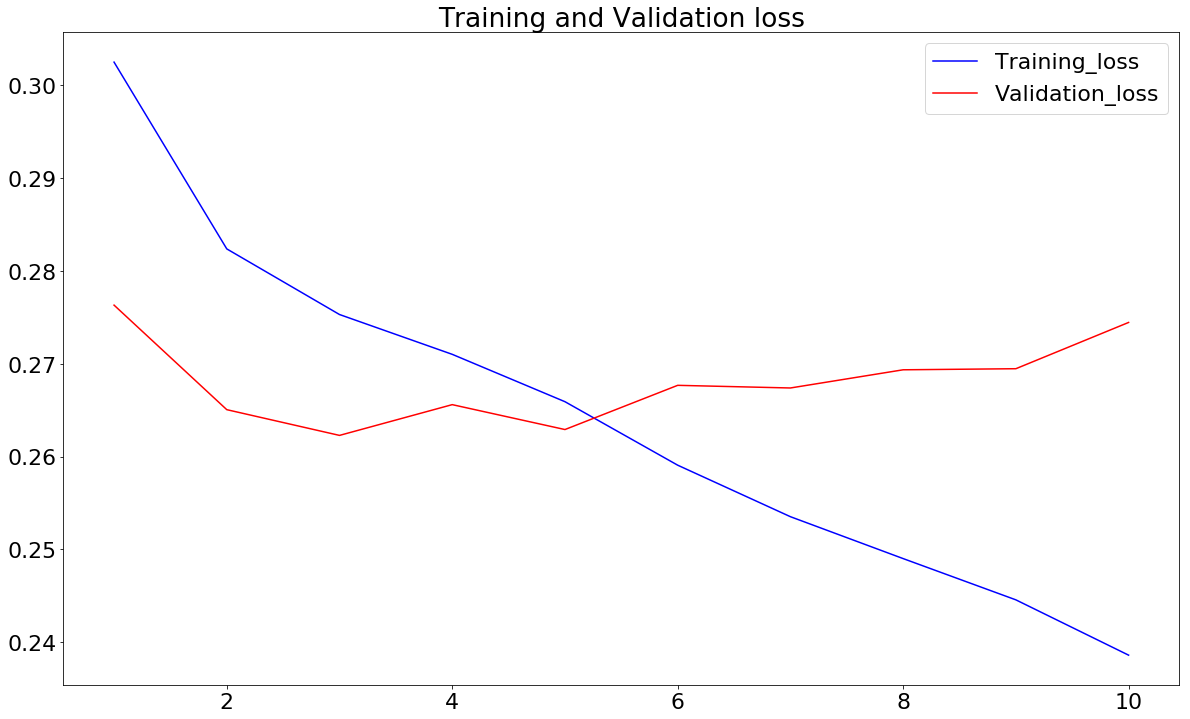

In [19]:
#plot result
import matplotlib.pyplot as plt

loss= history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure(figsize=(20, 12))
plt.rcParams.update({'font.size': 22})

plt.plot(epochs,loss,'b',label='Training_loss')
plt.plot(epochs,val_loss,'r',label='Validation_loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [20]:
final_mae=history.history['loss'][-1]
print(final_mae)

#reverse to get back the un standardized form

error_in_temp= final_mae*std[1]
print('error_in_temp is ',error_in_temp )

0.23861101225018502
error_in_temp is  2.112303766948678


### with bidirectional GRU 

In [23]:
from keras.models import Sequential
from keras.layers import GRU, Dense, CuDNNGRU, Bidirectional
from keras import optimizers

model2=Sequential()
model2.add(Bidirectional(CuDNNGRU(32),input_shape=(None,float_data.shape[-1])))
model2.add(Dense(1))
model2.compile(optimizer=optimizers.RMSprop(), loss='mae') 
history2=model2.fit_generator(train_gen, steps_per_epoch=600,epochs=10, validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
600/600 [==============================] - 20s 34ms/step - loss: 0.2951 - val_loss: 0.2700
Epoch 2/10
600/600 [==============================] - 20s 33ms/step - loss: 0.2745 - val_loss: 0.2772
Epoch 3/10
600/600 [==============================] - 20s 33ms/step - loss: 0.2656 - val_loss: 0.2689
Epoch 4/10
600/600 [==============================] - 20s 33ms/step - loss: 0.2592 - val_loss: 0.2692
Epoch 5/10
600/600 [==============================] - 20s 33ms/step - loss: 0.2518 - val_loss: 0.2713
Epoch 6/10
600/600 [==============================] - 20s 33ms/step - loss: 0.2454 - val_loss: 0.2701
Epoch 7/10
600/600 [==============================] - 20s 34ms/step - loss: 0.2375 - val_loss: 0.2809
Epoch 8/10
600/600 [==============================] - 20s 33ms/step - loss: 0.2295 - val_loss: 0.2743
Epoch 9/10
600/600 [==============================] - 20s 33ms/step - loss: 0.2235 - val_loss: 0.2825
Epoch 10/10
600/600 [==============================] - 20s 33ms/step - loss: 0.216

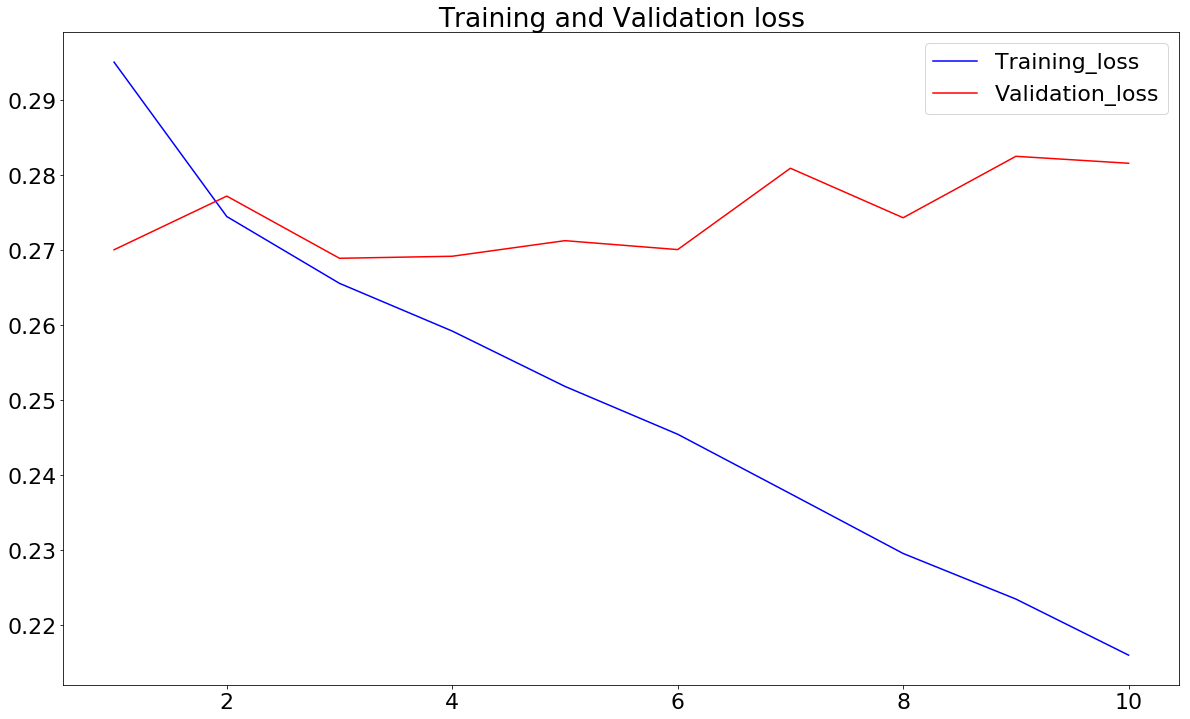

0.21597318251927694
error_in_temp is  1.91190240003271


In [24]:
#plot result
import matplotlib.pyplot as plt

loss= history2.history['loss']
val_loss=history2.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure(figsize=(20, 12))
plt.rcParams.update({'font.size': 22})

plt.plot(epochs,loss,'b',label='Training_loss')
plt.plot(epochs,val_loss,'r',label='Validation_loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

final_mae=history2.history['loss'][-1]
print(final_mae)

#reverse to get back the un standardized form

error_in_temp= final_mae*std[1]
print('error_in_temp is ',error_in_temp )

### With stack of GRU and dropout

In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense, CuDNNGRU, Bidirectional
from keras import optimizers

model3=Sequential()
model3.add(GRU(32,dropout=0.1,recurrent_dropout=0.5,return_sequences=True,input_shape=(None,float_data.shape[-1])))
model3.add(GRU(64,dropout=0.1,recurrent_dropout=0.5, activation='relu'))
model3.add(Dense(1))

model3.compile(optimizer=optimizers.RMSprop(), loss='mae') 
history3=model3.fit_generator(train_gen, steps_per_epoch=600,epochs=10, validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
#plot result
import matplotlib.pyplot as plt

loss= history3.history['loss']
val_loss=history3.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure(figsize=(20, 12))
plt.rcParams.update({'font.size': 22})

plt.plot(epochs,loss,'b',label='Training_loss')
plt.plot(epochs,val_loss,'r',label='Validation_loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

final_mae=history3.history['loss'][-1]
print(final_mae)

#reverse to get back the un standardized form

error_in_temp= final_mae*std[1]
print('error_in_temp is ',error_in_temp )